<a href="https://colab.research.google.com/github/flohmannjr/Carvana-Predict-Car-Prices/blob/main/Carvana_Predict_Car_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carvana - Predict Car Prices

https://www.kaggle.com/datasets/ravishah1/carvana-predict-car-Preços

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf

from tensorflow.data import AUTOTUNE, Dataset
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Configurações

In [2]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100

plt.style.use('seaborn-darkgrid')

## Constantes

In [43]:
SEMENTE = 2008193

TAMANHO_CNN = 128
TAMANHO_SAIDA = 1

ATIVACAO_CNN = 'relu'
ATIVACAO_SAIDA = 'linear'

PERDA = 'mse'
APRENDIZADO = 0.001

TAMANHO_LOTE = 256

ITERACOES = 1000
INICIALIZADOR = 'he_normal'

# Funções

In [4]:
def obter_metricas(y_test, y_pred):

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)

    return {'Mean Absolute Error': mae,
            'Root Mean Squared Error': rmse,
            'Mean Absolute Percentage Error': mape}

def obter_modelos(dados_treino,
                  dados_teste,
                  modelos_por_perda=5,
                  iteracoes=1000,
                  funcoes_perda=['mae', 'mse', 'mape']):

    conjunto_modelos = []

    for m in range(modelos_por_perda):

        for perda in funcoes_perda:

            modelo_nome = f'conjunto_modelo_{m}_perda_{perda}'

            print(f"Treinando modelo {modelo_nome} com {iteracoes} iterações.")

            modelo = Sequential(name=modelo_nome)

            [modelo.add(Dense(units=TAMANHO_CNN, kernel_initializer=INICIALIZADOR, activation=ATIVACAO_CNN, name=f'camada_relu_{c}')) for c in range(4)]
            modelo.add(Dense(units=TAMANHO_SAIDA, activation=ATIVACAO_SAIDA, name='camada_saida'))

            modelo.compile(loss=perda, optimizer=Adam(learning_rate=APRENDIZADO))
            
            modelo.fit(dados_treino,
                       epochs=iteracoes,
                       validation_data=dados_teste,
                       callbacks=[EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True),
                                  ReduceLROnPlateau(monitor='val_loss', patience=50)],
                       verbose=0)
            
            conjunto_modelos.append(modelo)

    return conjunto_modelos

def obter_previsoes(modelos, dados_teste):
    
    conjunto_previsoes = []

    for modelo in modelos:

        print(f'Prevendo com modelo {modelo.name}.')

        previsoes = modelo.predict(dados_teste)

        conjunto_previsoes.append(previsoes)
    
    return tf.constant(tf.squeeze(conjunto_previsoes))

# Dados

In [5]:
df = pd.read_csv('carvana.csv')

In [6]:
df = df.rename(columns={'Name': 'Descrição', 'Year': 'Ano', 'Miles': 'Milhagem', 'Price': 'Preço'})

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22000 entries, 0 to 21999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Descrição  22000 non-null  object
 1   Ano        22000 non-null  int64 
 2   Milhagem   22000 non-null  int64 
 3   Preço      22000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 687.6+ KB


## Pré-processamento

In [8]:
df['Ano'].value_counts()

2015       2542
2019       2281
2017       2152
2016       2107
2014       2053
           ... 
2018718       1
20191         1
20187         1
20211         1
20142         1
Name: Ano, Length: 211, dtype: int64

In [9]:
df['Ano'] = df['Ano'].astype(str).str[:4].astype(int)

In [10]:
df.duplicated().sum()

12683

In [11]:
df.drop_duplicates(inplace=True)

In [12]:
descricao = df['Descrição'].str.split()

df['Marca']       = descricao.str[0]
df['Modelo']      = descricao.str[1:].str.join(' ')
df['Esporte']     = 1 if 'Sport' in descricao else 0
df['Conversível'] = 1 if 'Cab' in descricao else 0

In [13]:
len(df['Marca'].unique()), len(df['Modelo'].unique())

(40, 402)

In [14]:
df.drop('Descrição', axis=1, inplace=True)

In [15]:
df[:5]

,Ano,Milhagem,Preço,Marca,Modelo,Esporte,Conversível
0,2018,41946,16990,Chevrolet,Trax,0,0
1,2020,45328,23990,GMC,Terrain,0,0
2,2012,81068,21590,Jeep,Wrangler,0,0
3,2019,35372,21590,Jeep,Renegade,0,0
4,2017,68992,22990,BMW,X,0,0


In [16]:
# df = pd.get_dummies(df)

In [17]:
df['Marca']  = df['Marca'].astype('category').cat.codes
df['Modelo'] = df['Modelo'].astype('category').cat.codes

In [18]:
df[:5]

,Ano,Milhagem,Preço,Marca,Modelo,Esporte,Conversível
0,2018,41946,16990,6,350,0,0
1,2020,45328,23990,11,338,0,0
2,2012,81068,21590,17,370,0,0
3,2019,35372,21590,17,265,0,0
4,2017,68992,22990,3,372,0,0


In [19]:
df['Ano'].value_counts()

2016    1077
2017    1075
2015     977
2018     968
2019     941
2020     907
2021     817
2014     810
2013     638
2012     440
2022     278
2011     201
2010     133
2009      52
2023       3
Name: Ano, dtype: int64

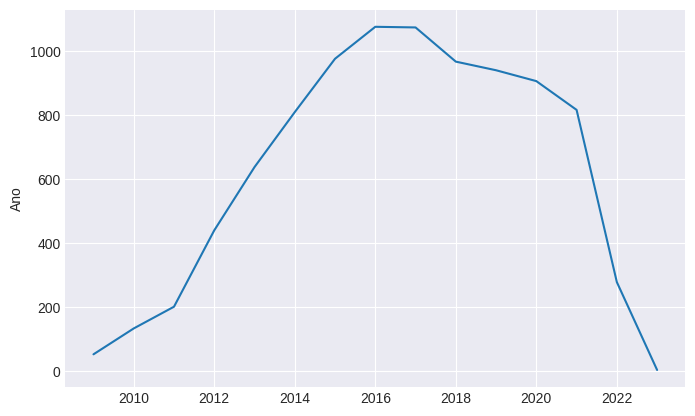

In [20]:
sns.lineplot(data=df['Ano'].value_counts());

## Separação treino e teste

In [21]:
X = df.drop('Preço', axis=1)
y = df['Preço']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEMENTE)

In [23]:
# scaler = MinMaxScaler()
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Criação de datasets

In [24]:
dataset_X_train    = Dataset.from_tensor_slices(X_train)
dataset_X_test     = Dataset.from_tensor_slices(X_test)
dataset_y_train    = Dataset.from_tensor_slices(y_train)
dataset_y_test     = Dataset.from_tensor_slices(y_test)

dataset_train = Dataset.zip((dataset_X_train, dataset_y_train))
dataset_test  = Dataset.zip((dataset_X_test, dataset_y_test))

dataset_train = dataset_train.batch(TAMANHO_LOTE).prefetch(AUTOTUNE)
dataset_test  = dataset_test.batch(TAMANHO_LOTE).prefetch(AUTOTUNE)

# Modelos

In [25]:
metricas = [None] * 20

## Modelo 1: Linear

In [26]:
%%time

lir = LinearRegression()

lir.fit(X_train, y_train)

y_pred = lir.predict(X_test)

metricas[1] = obter_metricas(y_test, y_pred)

CPU times: user 4.72 ms, sys: 1.91 ms, total: 6.63 ms
Wall time: 22.5 ms


In [27]:
metricas[1]

{'Mean Absolute Error': 4297.997165844517,
 'Root Mean Squared Error': 6652.370590947544,
 'Mean Absolute Percentage Error': 0.1848447729121194}

## Modelo 2: SVM

In [28]:
%%time

svr = SVR(kernel='linear', degree=2, shrinking=False)

svr.fit(X_train, y_train)

y_pred = svr.predict(X_test)

metricas[2] = obter_metricas(y_test, y_pred)

CPU times: user 2.16 s, sys: 151 ms, total: 2.32 s
Wall time: 2.27 s


In [29]:
metricas[2]

{'Mean Absolute Error': 4153.0714472594755,
 'Root Mean Squared Error': 7297.068150811122,
 'Mean Absolute Percentage Error': 0.16217062761039167}

## Modelo 3: Decision Tree

In [30]:
%%time

dtr = DecisionTreeRegressor()

dtr.fit(X_train, y_train)

y_pred = dtr.predict(X_test)

metricas[3] = obter_metricas(y_test, y_pred)

CPU times: user 22.7 ms, sys: 0 ns, total: 22.7 ms
Wall time: 25.3 ms


In [31]:
metricas[3]

{'Mean Absolute Error': 2829.932939914163,
 'Root Mean Squared Error': 5517.2024527873655,
 'Mean Absolute Percentage Error': 0.11425280996363406}

## Modelo 4: Random Forest

In [69]:
%%time

rfr = RandomForestRegressor(n_estimators=200, bootstrap=True, oob_score=True, warm_start=True)

rfr.fit(X_train, y_train)

y_pred = rfr.predict(X_test)

metricas[4] = obter_metricas(y_test, y_pred)

CPU times: user 4.05 s, sys: 0 ns, total: 4.05 s
Wall time: 4.21 s


In [70]:
metricas[4]

{'Mean Absolute Error': 2302.342893674637,
 'Root Mean Squared Error': 4373.923114901857,
 'Mean Absolute Percentage Error': 0.09395808385535512}

## Modelo 5: MLPR

In [44]:
%%time

mlp = MLPRegressor(max_iter=ITERACOES, learning_rate_init=APRENDIZADO)

mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

metricas[5] = obter_metricas(y_test, y_pred)

CPU times: user 3min 56s, sys: 3min 15s, total: 7min 11s
Wall time: 4min 5s


In [45]:
metricas[5]

{'Mean Absolute Error': 4053.948186226098,
 'Root Mean Squared Error': 6401.839775397952,
 'Mean Absolute Percentage Error': 0.1732037049919721}

## Modelo 6: Dense

In [46]:
%%time

tf.random.set_seed(SEMENTE)

tfd = Sequential()

[tfd.add(Dense(units=TAMANHO_CNN, activation=ATIVACAO_CNN)) for _ in range(4)]
tfd.add(Dense(units=TAMANHO_SAIDA, activation=ATIVACAO_SAIDA))

tfd.compile(loss=PERDA,
            optimizer=Adam(learning_rate=APRENDIZADO))

tfd.fit(dataset_train,
        epochs=ITERACOES,
        validation_data=dataset_test,
        callbacks=[EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True),
                   ReduceLROnPlateau(monitor='val_loss', patience=50)],
        verbose=0)

y_pred = tfd.predict(dataset_test)

metricas[6] = obter_metricas(y_test, tf.squeeze(y_pred))

8/8 [==============================] - 0s 2ms/step
CPU times: user 2min 43s, sys: 13.1 s, total: 2min 56s
Wall time: 2min 22s


In [47]:
metricas[6]

{'Mean Absolute Error': 3451.0677359257643,
 'Root Mean Squared Error': 5530.0308321979755,
 'Mean Absolute Percentage Error': 0.1497426000288909}

## Modelo 7: Ensemble

In [48]:
%%time

conjunto_modelos         = obter_modelos(dataset_train, dataset_test)
conjunto_previsoes       = obter_previsoes(conjunto_modelos, dataset_test)
conjunto_previsoes_media = tf.reduce_mean(conjunto_previsoes, axis=0)

metricas[7] = obter_metricas(y_test, tf.squeeze(conjunto_previsoes_media))

Treinando modelo conjunto_modelo_0_perda_mae com 1000 iterações.
Treinando modelo conjunto_modelo_0_perda_mse com 1000 iterações.
Treinando modelo conjunto_modelo_0_perda_mape com 1000 iterações.
Treinando modelo conjunto_modelo_1_perda_mae com 1000 iterações.
Treinando modelo conjunto_modelo_1_perda_mse com 1000 iterações.
Treinando modelo conjunto_modelo_1_perda_mape com 1000 iterações.
Treinando modelo conjunto_modelo_2_perda_mae com 1000 iterações.
Treinando modelo conjunto_modelo_2_perda_mse com 1000 iterações.
Treinando modelo conjunto_modelo_2_perda_mape com 1000 iterações.
Treinando modelo conjunto_modelo_3_perda_mae com 1000 iterações.
Treinando modelo conjunto_modelo_3_perda_mse com 1000 iterações.
Treinando modelo conjunto_modelo_3_perda_mape com 1000 iterações.
Treinando modelo conjunto_modelo_4_perda_mae com 1000 iterações.
Treinando modelo conjunto_modelo_4_perda_mse com 1000 iterações.
Treinando modelo conjunto_modelo_4_perda_mape com 1000 iterações.
Prevendo com modelo 

In [49]:
metricas[7]

{'Mean Absolute Error': 2931.466928899544,
 'Root Mean Squared Error': 5614.863645143833,
 'Mean Absolute Percentage Error': 0.1145831858813604}

# Comparação dos modelos

In [71]:
df['Preço'].describe()

count      9317.000000
mean      21782.642696
std        7930.858826
min       10990.000000
25%       16990.000000
50%       19990.000000
75%       23990.000000
max      102990.000000
Name: Preço, dtype: float64

In [72]:
df_metricas = pd.DataFrame([m for m in metricas if m is not None])
df_metricas.T

,0,1,2,3,4,5,6
Mean Absolute Error,4297.997166,4153.071447,2829.932940,2302.342894,4053.948186,3451.067736,2931.466929
Root Mean Squared Error,6652.370591,7297.068151,5517.202453,4373.923115,6401.839775,5530.030832,5614.863645
Mean Absolute Percentage Error,0.184845,0.162171,0.114253,0.093958,0.173204,0.149743,0.114583


In [73]:
df_metricas['Root Mean Squared Error'].sort_values()

3    4373.923115
2    5517.202453
5    5530.030832
6    5614.863645
4    6401.839775
0    6652.370591
1    7297.068151
Name: Root Mean Squared Error, dtype: float64